
🚀 Spaceship Titanic — Progress Report Rescue Notebook
Run cells top → bottom. This notebook:


**Team rule tree:** Split on `CryoSleep → VIP → HomePlanet → Destination`.  
**Stopping:** ≥95% Y, ≤5% N, `n<10` majority, or no features left → majority.  
**Missing values** are treated as literal `"NA"` categories.

This notebook gives you:
1. Minimal EDA 
2. Loads our cleaned training data 
3. A readable tree trained on an 80/20 split + metrics
4. Ttrains our fixed‑order decision tree (CryoSleep → VIP → HomePlanet → Destination)
5. Prints validation metrics for the progress report
6. Please add as needed




In [57]:
# 1) Imports
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Tuple
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

FEATURE_ORDER = ["CryoSleep", "VIP", "HomePlanet", "Destination"]
TARGET = "Transported"
RANDOM_STATE = 42


In [58]:
# 2) Load + prep

df_clean = None
for name in ["clean_encoded", "train_clean", "train_p", "df_clean", "cleaned_train"]:
    if name in globals() and isinstance(globals()[name], pd.DataFrame) and len(globals()[name]) > 0:
        df_clean = globals()[name].copy()
        print(f"✅ Using cleaned DataFrame in memory: {name} shape={df_clean.shape}")
        break

# Fallback to CSVs if not found in memory:
if df_clean is None:
    for p in ["train_clean.csv", "data/train_clean.csv", "train.csv", "data/train.csv"]:
        if os.path.exists(p):
            df_clean = pd.read_csv(p)
            print(f"✅ Loaded cleaned data from: {p} shape={df_clean.shape}")
            break
if df_clean is None:
    raise FileNotFoundError("Could not find a cleaned DataFrame or a train*.csv file.")

# Normalize column names
lower_to_actual = {c.lower().strip(): c for c in df_clean.columns}
rename = {}
for want in FEATURE_ORDER + [TARGET, "PassengerId"]:
    if want not in df_clean.columns:
        key = want.lower().strip()
        if key in lower_to_actual:
            rename[lower_to_actual[key]] = want
if rename:
    print("Renaming columns:", rename)
    df_clean = df_clean.rename(columns=rename)

# Keep only what we need (don’t fail if some features are missing)
keep = [c for c in ["PassengerId"] + FEATURE_ORDER + [TARGET] if c in df_clean.columns]
df = df_clean[keep].copy()

# Ensure categorical features are strings with 'NA' for missing
for col in [c for c in FEATURE_ORDER if c in df.columns]:
    df[col] = df[col].where(df[col].notna(), "NA").astype(str)

# Ensure target is boolean
if TARGET in df.columns and df[TARGET].dtype != bool:
    df[TARGET] = df[TARGET].map({True: True, False: False, "True": True, "False": False, 1: True, 0: False}).astype(bool)

print("Columns in df:", list(df.columns))
if TARGET not in df.columns:
    raise KeyError("Target column 'Transported' is missing. Make sure you're loading the training set (not the test set).")


✅ Loaded cleaned data from: train_clean.csv shape=(6606, 14)
Columns in df: ['PassengerId', 'CryoSleep', 'VIP', 'HomePlanet', 'Destination', 'Transported']


### 3) Mini EDA — counts and two simple plots

,CryoSleep,VIP,HomePlanet,Destination,sum,count,not_transported,pct_transported
0,False,False,Earth,55 Cancri e,162,388,226,0.4175
1,False,False,Earth,PSO J318.5-22,88,279,191,0.3154
2,False,False,Earth,TRAPPIST-1e,550,1809,1259,0.3040
3,False,False,Europa,55 Cancri e,123,306,183,0.4020
4,False,False,Europa,TRAPPIST-1e,228,550,322,0.4145
5,False,False,Mars,55 Cancri e,35,90,55,0.3889
6,False,False,Mars,PSO J318.5-22,8,23,15,0.3478
7,False,False,Mars,TRAPPIST-1e,185,684,499,0.2705
8,False,True,Europa,55 Cancri e,13,44,31,0.2955
9,False,True,Europa,PSO J318.5-22,4,8,4,0.5000



Value counts for CryoSleep:
CryoSleep
False    4274
True     2332
Name: count, dtype: int64

Value counts for VIP:
VIP
False    6444
True      162
Name: count, dtype: int64

Value counts for HomePlanet:
HomePlanet
Earth     3566
Europa    1673
Mars      1367
Name: count, dtype: int64

Value counts for Destination:
Destination
TRAPPIST-1e      4576
55 Cancri e      1407
PSO J318.5-22     623
Name: count, dtype: int64


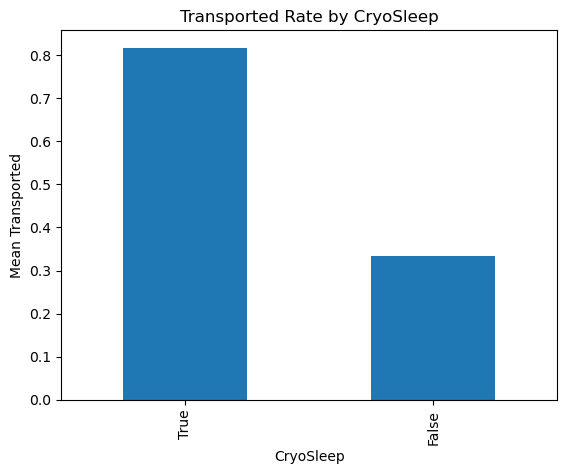

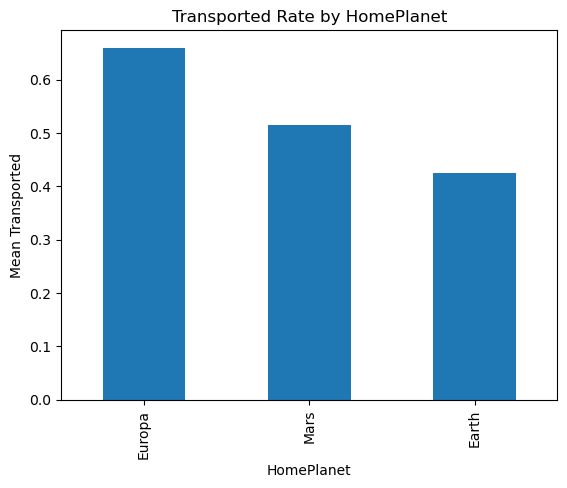

In [59]:
import matplotlib.pyplot as plt

# Group counts table used by the hand-made tree
grouped = df.groupby(FEATURE_ORDER)[TARGET].agg(['sum', 'count'])
grouped['not_transported'] = grouped['count'] - grouped['sum']
grouped['pct_transported'] = (grouped['sum'] / grouped['count']).round(4)
display(grouped.reset_index().head(15))

# Quick sanity: value counts per feature (helps spot weird labels)
for col in FEATURE_ORDER:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts(dropna=False).head(10))

# Plot 1: Transported rate by CryoSleep
rate_by_cryo = df.groupby("CryoSleep")[TARGET].mean().sort_values(ascending=False)
plt.figure()
rate_by_cryo.plot(kind="bar")
plt.title("Transported Rate by CryoSleep")
plt.xlabel("CryoSleep")
plt.ylabel("Mean Transported")
plt.show()

# Plot 2: Transported rate by HomePlanet
rate_by_home = df.groupby("HomePlanet")[TARGET].mean().sort_values(ascending=False)
plt.figure()
rate_by_home.plot(kind="bar")
plt.title("Transported Rate by HomePlanet")
plt.xlabel("HomePlanet")
plt.ylabel("Mean Transported")
plt.show()



### 4) Build the fixed-order decision tree

In [60]:

@dataclass
class Node:
    depth: int
    n: int
    positives: int
    negatives: int
    rate: float
    is_leaf: bool
    prediction: Optional[bool] = None
    feature: Optional[str] = None
    children: Dict[Any, "Node"] = field(default_factory=dict)
    reason: str = ""

    def pretty(self, indent: str = "  ") -> str:
        line = f"{indent*self.depth}Node(depth={self.depth}, n={self.n}, pos={self.positives}, neg={self.negatives}, rate={self.rate:.3f})"
        if self.is_leaf:
            lab = "Y" if self.prediction else "N"
            return f"{line} -> LEAF: predict {lab} ({self.reason})"
        s = f"{line} -> split on [{self.feature}]"
        for val, child in self.children.items():
            s += "\n" + f"{indent*self.depth}- if {self.feature} == {val!r}:\n" + child.pretty(indent)
        return s

def class_stats(y: pd.Series):
    n = len(y)
    if n == 0:
        return 0, 0, 0.0
    pos = int((y == True).sum())
    neg = n - pos
    rate = pos / n
    return pos, neg, rate

def majority_bool(pos: int, neg: int) -> bool:
    return pos >= neg

def build_tree(df_, features: List[str], depth: int = 0) -> Node:
    pos, neg, rate = class_stats(df_[TARGET])
    n = len(df_)

    # Stopping rules
    if n > 0 and rate >= 0.95:
        return Node(depth, n, pos, neg, rate, True, True, None, {}, "≥95% transported (Y)")
    if n > 0 and rate <= 0.05:
        return Node(depth, n, pos, neg, rate, True, False, None, {}, "≤5% transported (N)")
    if n < 10:
        return Node(depth, n, pos, neg, rate, True, majority_bool(pos, neg), None, {}, "n<10 -> majority")
    if not features:
        return Node(depth, n, pos, neg, rate, True, majority_bool(pos, neg), None, {}, "no features -> majority")

    feat = features[0]
    node = Node(depth, n, pos, neg, rate, False, None, feat, {}, "")
    values = list(pd.Series(df_[feat]).unique()) if feat in df_.columns else []
    if "NA" not in values:
        values.append("NA")

    for v in values:
        sub = df_[df_[feat] == v] if feat in df_.columns else df_.iloc[0:0]
        if len(sub) == 0:
            child = Node(depth+1, 0, 0, 0, rate, True, majority_bool(pos, neg), None, {}, "empty -> parent majority")
        else:
            child = build_tree(sub, features[1:], depth+1)
        node.children[v] = child
    return node

def predict_one(node: Node, row: pd.Series) -> bool:
    while not node.is_leaf:
        feat = node.feature
        val = str(row.get(feat, "NA"))
        if val in node.children:
            node = node.children[val]
        elif "NA" in node.children:
            node = node.children["NA"]
        else:
            return majority_bool(node.positives, node.negatives)
    return bool(node.prediction)

def predict_df(node: Node, df_: pd.DataFrame) -> np.ndarray:
    return np.array([predict_one(node, r) for _, r in df_.iterrows()], dtype=bool)



### 5) Train/valid split, fit, metrics, and readable tree

In [61]:

# === Cell 5: Train/valid split → metrics ===

if TARGET not in df.columns:
    raise KeyError("Target column 'Transported' is missing in df. Cannot train.")

features_to_use = [f for f in FEATURE_ORDER if f in df.columns]
if not features_to_use:
    raise ValueError("None of the expected features are present. Check your cleaned dataset.")

# 80/20 split
tr, va = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE, stratify=df[TARGET])

# Train on the training fold
tree = build_tree(tr, features_to_use)
print("=== TREE (trained on 80%) ===")
print(tree.pretty())

# Validate
va_pred = predict_df(tree, va)
acc = accuracy_score(va[TARGET], va_pred)
prec = precision_score(va[TARGET], va_pred, zero_division=0)
rec  = recall_score(va[TARGET], va_pred, zero_division=0)
f1   = f1_score(va[TARGET], va_pred, zero_division=0)
cm   = confusion_matrix(va[TARGET], va_pred)

print(f"\n[Validation] Accuracy={acc:.4f}  Precision={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}")
print("Confusion Matrix:\n", cm)



=== TREE (trained on 80%) ===
Node(depth=0, n=5284, pos=2661, neg=2623, rate=0.504) -> split on [CryoSleep]
- if CryoSleep == 'False':
  Node(depth=1, n=3409, pos=1125, neg=2284, rate=0.330) -> split on [VIP]
  - if VIP == 'False':
    Node(depth=2, n=3311, pos=1100, neg=2211, rate=0.332) -> split on [HomePlanet]
    - if HomePlanet == 'Europa':
      Node(depth=3, n=697, pos=280, neg=417, rate=0.402) -> split on [Destination]
      - if Destination == '55 Cancri e':
        Node(depth=4, n=249, pos=98, neg=151, rate=0.394) -> LEAF: predict N (no features -> majority)
      - if Destination == 'TRAPPIST-1e':
        Node(depth=4, n=448, pos=182, neg=266, rate=0.406) -> LEAF: predict N (no features -> majority)
      - if Destination == 'NA':
        Node(depth=4, n=0, pos=0, neg=0, rate=0.402) -> LEAF: predict N (empty -> parent majority)
    - if HomePlanet == 'Mars':
      Node(depth=3, n=652, pos=181, neg=471, rate=0.278) -> split on [Destination]
      - if Destination == 'TRAPPIST

### 6) Refit on full train and (optional) submission

In [62]:

full_tree = build_tree(df, features_to_use)
print("=== TREE (refit on 100% train) ===")
print(full_tree.pretty())

# Optional submission
test = None
for p in ["test.csv", "data/test.csv"]:
    if os.path.exists(p):
        test = pd.read_csv(p)
        print(f"Found test set at: {p}")
        break

if test is not None and "PassengerId" in test.columns:
    for col in [c for c in features_to_use if c in test.columns]:
        test[col] = test[col].where(test[col].notna(), "NA").astype(str)
    test_pred = predict_df(full_tree, test)
    sub = pd.DataFrame({"PassengerId": test["PassengerId"], "Transported": test_pred})
    sub.to_csv("submission.csv", index=False)
    print(f"Wrote submission.csv with {len(sub)} rows.")
else:
    print("No test.csv (or PassengerId missing) — skipping submission.")


=== TREE (refit on 100% train) ===
Node(depth=0, n=6606, pos=3327, neg=3279, rate=0.504) -> split on [CryoSleep]
- if CryoSleep == 'False':
  Node(depth=1, n=4274, pos=1422, neg=2852, rate=0.333) -> split on [VIP]
  - if VIP == 'False':
    Node(depth=2, n=4129, pos=1379, neg=2750, rate=0.334) -> split on [HomePlanet]
    - if HomePlanet == 'Europa':
      Node(depth=3, n=856, pos=351, neg=505, rate=0.410) -> split on [Destination]
      - if Destination == 'TRAPPIST-1e':
        Node(depth=4, n=550, pos=228, neg=322, rate=0.415) -> LEAF: predict N (no features -> majority)
      - if Destination == '55 Cancri e':
        Node(depth=4, n=306, pos=123, neg=183, rate=0.402) -> LEAF: predict N (no features -> majority)
      - if Destination == 'NA':
        Node(depth=4, n=0, pos=0, neg=0, rate=0.410) -> LEAF: predict N (empty -> parent majority)
    - if HomePlanet == 'Earth':
      Node(depth=3, n=2476, pos=800, neg=1676, rate=0.323) -> split on [Destination]
      - if Destination == 

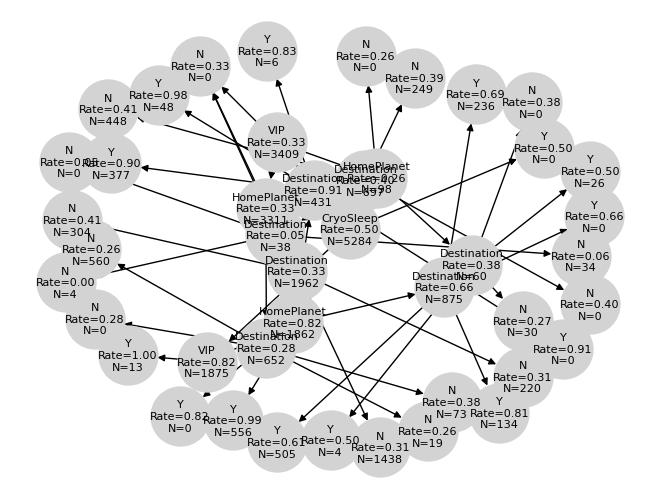

In [63]:
# 7) A little visual...not perfect 
import networkx as nx
import matplotlib.pyplot as plt

def build_graph(node, G=None, parent=None, edge_label="root"):
    if G is None:
        G = nx.DiGraph()
    label = f"{node.feature or ('Y' if node.prediction else 'N')}\nRate={node.rate:.2f}\nN={node.n}"
    G.add_node(label)
    if parent:
        G.add_edge(parent, label, label=edge_label)
    for val, child in node.children.items():
        build_graph(child, G, label, edge_label=val)
    return G

G = build_graph(tree)
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=1800, node_color="lightgray", font_size=8)
plt.show()